In [1]:
import matplotlib.pyplot as plt
import numpy as np
from plyfile import PlyData
import open3d as o3d

C:\Users\Dima\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
surface2 = PlyData.read('Image0008.ply')
surface1 = PlyData.read('Image0009.ply')
surface3 = PlyData.read('Image0010.ply')
surface4 = PlyData.read('Image0011.ply')
surface5 = PlyData.read('Image0012.ply')
vertices = surface2['vertex'].data
faces = surface2['face'].data

In [3]:
surface2

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float')), count=65536, comments=[]), PlyElement('face', (PlyListProperty('vertex_index', 'uchar', 'int'),), count=130050, comments=[])), text=True, byte_order='=', comments=['exported from Gwyddion', 'title HeightRetrace'], obj_info=[])

In [4]:
vertices

array([(  0.,   0., 26.882784), (  1.,   0., 27.028566),
       (  2.,   0., 27.447363), ..., (253., 255., 13.016548),
       (254., 255., 11.755153), (255., 255., 10.47204 )],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4')])

In [5]:
faces

array([(array([  0, 257, 256]),), (array([  0,   1, 257]),),
       (array([  1, 258, 257]),), ..., (array([65277, 65278, 65534]),),
       (array([65278, 65535, 65534]),), (array([65278, 65279, 65535]),)],
      dtype=[('vertex_index', 'O')])

In [132]:

pcd = o3d.io.read_point_cloud('Image0009.ply')
o3d.visualization.draw_geometries([pcd])


In [7]:
def compute_normal(A, B, C):
    AB = B - A
    AC = C - A
    N = np.cross(AB, AC)
    return N / np.linalg.norm(N)  # Normalized normal

In [8]:
vertices_np = np.array(vertices.tolist())
faces_np = np.array([face[0] for face in faces])
A = vertices_np[faces_np[:, 0]]
B = vertices_np[faces_np[:, 1]]
C = vertices_np[faces_np[:, 2]]
# Calculate edge vectors
AB = B - A
AC = C - A
# Compute normals
normals = np.cross(AB, AC)
# Normalize the normals
normals = normals / np.linalg.norm(normals, axis=1)[:, np.newaxis]

In [9]:
normals

array([[-0.26106911,  0.489305  ,  0.8321199 ],
       [-0.13320791,  0.38383194,  0.91374433],
       [-0.39667893,  0.35550964,  0.8463207 ],
       ...,
       [ 0.80488174,  0.02952603,  0.59270026],
       [ 0.78837944,  0.03060839,  0.61442736],
       [ 0.82159479, -0.06699511,  0.56612159]])

(-1.0, 81.0)

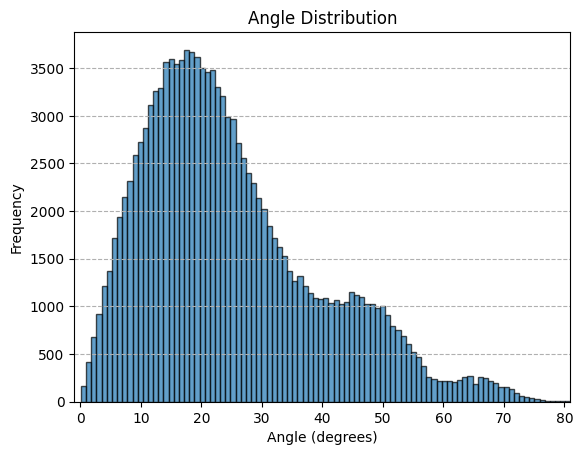

In [10]:
z_norm = np.array([0, 0, 1])
dot_products = np.dot(normals, z_norm)
cosine_angles = dot_products
# Compute the angles using arccosine (result is in radians)
angles_radians = np.arccos(np.clip(cosine_angles, -1.0, 1.0))
# If you want the angles in degrees
angles_degrees = np.degrees(angles_radians)

plt.hist(angles_degrees, bins=100, edgecolor='black', alpha=0.7)
plt.title('Angle Distribution')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--')
plt.xlim(-1, 81)

In [57]:
# Data from the experiment
sample_sizes = [10e-6, 10e-6]
resolution = [256, 256]
pixel_sizes = np.array(sample_sizes) / np.array(resolution)
wavelength = 0.5e-6
criteria = 1 / 8
assert pixel_sizes[0] == pixel_sizes[1], f'The mesh is not uniform'
pixel_size = pixel_sizes[0]

In [38]:

# size the light cannot separate
face_smooth_size = wavelength * criteria
# how many pixels we are avg through along 1D (it will be 2D amount*amount)
amount_pixels_smooth = int(np.ceil(face_smooth_size / pixel_size))
amount_pixels_smooth

2

In [28]:
import torch
import torch.nn as nn

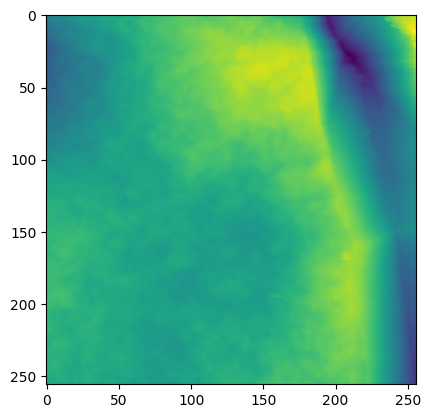

In [46]:
# Extract x, y, and z arrays
x = vertices_np[:, 0]
y = vertices_np[:, 1]
z = vertices_np[:, 2]
# Get unique x and y values
x_unique = np.unique(x)
y_unique = np.unique(y)
# Create the XY mesh
X, Y = np.meshgrid(x_unique, y_unique)
# Reshape Z values into a 2D array
Z = z.reshape(len(x_unique), len(y_unique))
plt.imshow(Z)

In [54]:
def compute_normal(v1, v2, v3):
    """Compute the normal vector for the triangle defined by vertices v1, v2, and v3."""
    u = v2 - v1
    v = v3 - v1
    normal = np.cross(u, v)
    return normal / np.linalg.norm(normal)

def normals_triangles(Z):
    normals = []

    # Iterate through pixels
    for i in range(Z.shape[0]-1):
        for j in range(Z.shape[1]-1):
            # Define vertices for the quad
            bottom_left  = np.array([i,   j,   Z[i, j]])
            bottom_right = np.array([i,   j+1, Z[i, j+1]])
            top_left     = np.array([i+1, j,   Z[i+1, j]])
            top_right    = np.array([i+1, j+1, Z[i+1, j+1]])

            # Calculate normals for two triangles within the quad
            triangle1_normal = compute_normal(bottom_left, top_left, bottom_right)
            triangle2_normal = compute_normal(bottom_right, top_left, top_right)

            normals.append(triangle1_normal)
            normals.append(triangle2_normal)

    # Convert normals list to 2D array with an extra dimension for each triangle
    normals = np.array(normals).reshape(Z.shape[0]-1, Z.shape[1]-1, 2, 3)
    return normals

def normals_triangles_fast(Z):
    X, Y = np.meshgrid(np.arange(Z.shape[1]), np.arange(Z.shape[0]))
    # Slice arrays to get coordinates and heights for the triangles
    bl = np.stack([X[:-1, :-1], Y[:-1, :-1], Z[:-1, :-1]], axis=-1)
    br = np.stack([X[:-1, 1:],  Y[:-1, 1:],  Z[:-1, 1:]], axis=-1)
    tl = np.stack([X[1:, :-1],  Y[1:, :-1],  Z[1:, :-1]], axis=-1)
    tr = np.stack([X[1:, 1:],   Y[1:, 1:],   Z[1:, 1:]],  axis=-1)
    # Compute the vectors of the triangles
    u1 = tl - bl
    v1 = br - bl
    u2 = br - tr
    v2 = tl - tr
    # Compute normals
    normal1 = np.cross(u1, v1)
    normal2 = np.cross(u2, v2)
    # Normalize
    normal1 /= np.linalg.norm(normal1, axis=-1, keepdims=True)
    normal2 /= np.linalg.norm(normal2, axis=-1, keepdims=True)

    # Combine the normals for the two triangles into one array
    normals = np.stack([normal1, normal2], axis=2)
    return normals

In [51]:
normals_triangles_2D = normals_triangles(Z)
print(normals_triangles_2D.shape)

(255, 255, 2, 3)


In [64]:
def avg_pooling_vector(normals, size=2, stride=1):
    """
    Compute average normal for regions of size SxS with stride H from the normals array.

    :param normals: A 4D array of shape (height, width, 2, 3) where the third dimension is for two triangles per pixel
                    and the fourth dimension is for the x, y, z components of the normal.
    :param S: Size of the region.
    :param H: Stride.
    :return: A 3D array containing the average normals for each region.
    """
    S = size
    H = stride
    shape = ((normals.shape[0] - S) // H + 1,
             (normals.shape[1] - S) // H + 1,
             S, S, 2, 3)

    strides = (normals.strides[0] * H,
               normals.strides[1] * H) + normals.strides

    regions = np.lib.stride_tricks.as_strided(normals, shape=shape, strides=strides)

    avg_normals = np.mean(regions, axis=(2, 3, 4))

    # Normalize
    avg_normals /= np.linalg.norm(avg_normals, axis=-1, keepdims=True)

    return avg_normals



In [95]:
normals_triangles_2D = normals_triangles_fast(Z)
print(normals_triangles_2D.shape)
# print(normals_triangles_2D)
normals_avg = avg_pooling_vector(normals_triangles_2D, size=1, stride=1)
normals_avg2 = avg_pooling_vector(normals_triangles_2D, size=2, stride=1)
normals_avg3 = avg_pooling_vector(normals_triangles_2D, size=3, stride=1)
normals_avg4 = avg_pooling_vector(normals_triangles_2D, size=4, stride=1)
normals_avg5 = avg_pooling_vector(normals_triangles_2D, size=5, stride=1)
normals_avg6 = avg_pooling_vector(normals_triangles_2D, size=5, stride=1)
normals_avg20 = avg_pooling_vector(normals_triangles_2D, size=20, stride=1)
# print(normals_avg)
print(normals_avg.shape)


(255, 255, 2, 3)
(255, 255, 3)


In [87]:
def find_angles_degree(normals):
    z_norm = (0, 0, -1)
    dot_products = np.dot(normals, z_norm)
    cosine_angles = dot_products
    angles_radians = np.arccos(np.clip(cosine_angles, -1.0, 1.0))
    angles_degrees = np.degrees(angles_radians)
    return angles_degrees

In [96]:
angles_avg1 = find_angles_degree(normals_avg)
angles_avg2 = find_angles_degree(normals_avg2)
angles_avg3 = find_angles_degree(normals_avg3)
angles_avg4 = find_angles_degree(normals_avg4)
angles_avg5 = find_angles_degree(normals_avg5)
angles_avg6 = find_angles_degree(normals_avg6)
angles_avg20 = find_angles_degree(normals_avg6)

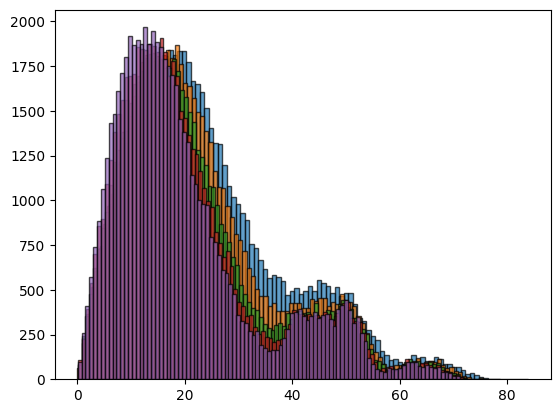

In [98]:
plt.hist(angles_avg1.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.hist(angles_avg2.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.hist(angles_avg3.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.hist(angles_avg4.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.hist(angles_avg5.flatten(), bins=100, edgecolor='black', alpha=0.7)
# plt.hist(angles_avg6.flatten(), bins=100, edgecolor='black', alpha=0.7)
# plt.hist(angles_avg20.flatten(), bins=100, edgecolor='black', alpha=0.7)
# plt.hist(angles_avg44.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.show()

625.0


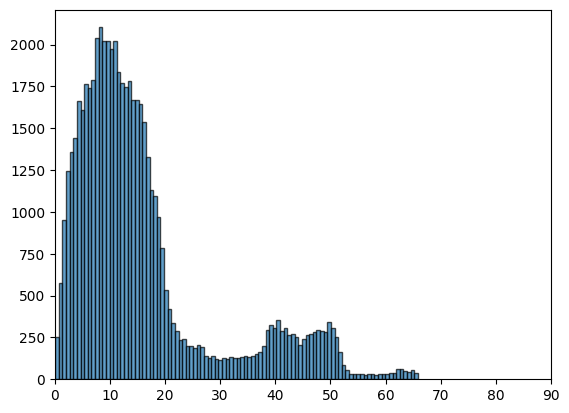

In [131]:
avg_amount = 16
print(pixel_size * 1e9 * avg_amount)
normals_avgX = avg_pooling_vector(normals_triangles_2D, size=avg_amount, stride=1)
angles_avgX = find_angles_degree(normals_avgX)
plt.hist(angles_avgX.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.xlim(0, 90)
plt.show()

[[151.04781408 149.28294199 144.10558479 ... 135.22452748 136.31312357
  135.23474263]
 [157.6638937  150.00170784 146.4327822  ... 140.61823698 140.89984674
  142.49789235]
 [155.52851963 145.85698502 146.43383496 ... 155.44466946 155.77178704
  162.22730233]
 ...
 [170.84640766 168.7358245  174.96855851 ... 127.58706619 123.39366825
  123.44992758]
 [163.86658333 164.11692575 164.03176191 ... 128.69855511 125.52680151
  123.93524084]
 [165.69908383 165.36130373 169.56072089 ... 127.61372834 127.31292984
  126.23782949]]


(-1.0, 81.0)

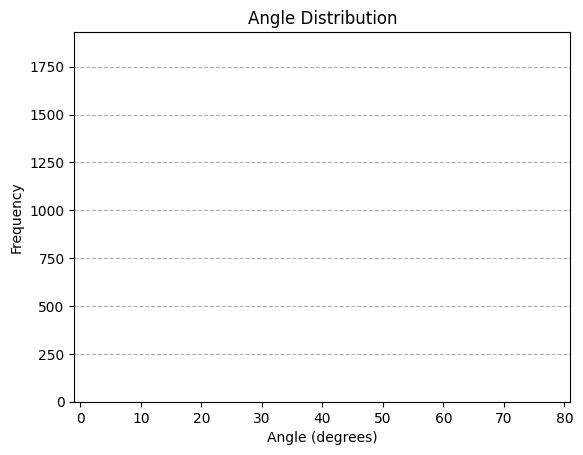

In [77]:
z_norm = (0, 0, 1)
dot_products = np.dot(normals_avg, z_norm)
cosine_angles = dot_products
# Compute the angles using arccosine (result is in radians)
angles_radians = np.arccos(np.clip(cosine_angles, -1.0, 1.0))
# If you want the angles in degrees
angles_degrees = np.degrees(angles_radians)
print(angles_degrees)
plt.hist(angles_degrees.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.title('Angle Distribution')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--')
plt.xlim(-1, 81)

In [151]:
def open_ply(path, plot3D=False):
    surface = PlyData.read(path)
    vertices = surface['vertex'].data
    faces = surface['face'].data
    print(f"resolution: {int(np.sqrt(len(vertices)))}")
    if plot3D:
        pcd = o3d.io.read_point_cloud(path)
        o3d.visualization.draw_geometries([pcd])
    return vertices, faces

def get_the_grid(vertices, plot2D=False):
    vertices_np = np.array(vertices.tolist())
    # faces_np = np.array([face[0] for face in faces])
    # Extract x, y, and z arrays
    x = vertices_np[:, 0]
    y = vertices_np[:, 1]
    z = vertices_np[:, 2]
    # Get unique x and y values
    x_unique = np.unique(x)
    y_unique = np.unique(y)
    # Create the XY mesh
    X, Y = np.meshgrid(x_unique, y_unique)
    # Reshape Z values into a 2D array
    Z = z.reshape(len(x_unique), len(y_unique))
    if plot2D:
        plt.imshow(Z)
        plt.show()
    return X, Y, Z

In [141]:
# 7 5.1e+07
# 8 2.55e+07
# 9 2.55e+07
# 10 1.27e+07
# 11 2.54e+06
vertices8, faces8 = open_ply("Image0008.ply", plot3D=False)
vertices9, faces9 = open_ply("Image0009.ply", plot3D=False)
vertices10, faces10 = open_ply("Image0010.ply", plot3D=False)
vertices11, faces11 = open_ply("Image0011.ply", plot3D=False)
vertices7, faces7 = open_ply("Image0007.ply", plot3D=False)

resolution: 256
resolution: 256
resolution: 128
resolution: 128
resolution: 256


In [214]:
# Data from the experiment
sample_sizes = [10e-6, 10e-6, 10e-6, 50e-6]
resolution = [256, 256, 128, 128]
pixel_sizes = np.array(sample_sizes) / np.array(resolution)
wavelength = 0.5e-6
# wavelength = 1e-6
criteria = 2.
# size the light cannot separate
face_smooth_size = wavelength * criteria
print(f"Averaging distance: {face_smooth_size}m")
# how many pixels we are avg through along 1D (it will be 2D amount*amount)
pixels_amount_per_avg = np.round(pixel_sizes ** -1 * face_smooth_size).astype(int)
print(f"Pixels used for averaging: {pixels_amount_per_avg}")
print(f"Sizes used for averaging: {pixels_amount_per_avg * pixel_sizes}")

Averaging distance: 3.9999999999999996e-05m
Pixels used for averaging: [1024 1024  512  102]
Sizes used for averaging: [4.000000e-05 4.000000e-05 4.000000e-05 3.984375e-05]


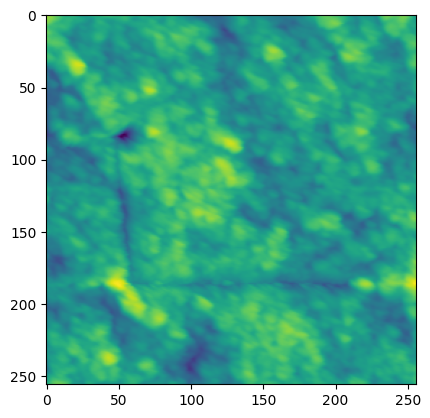

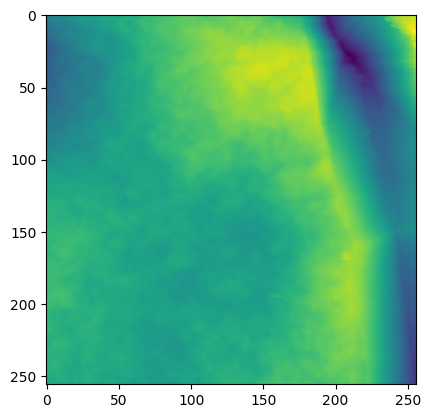

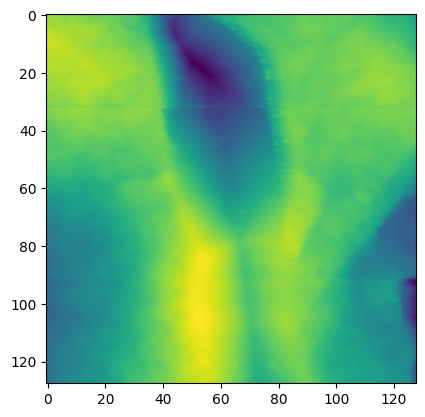

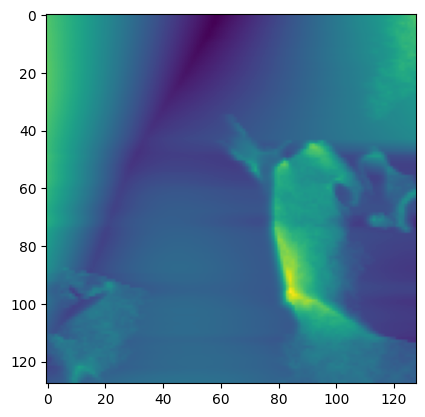

In [215]:
X8, Y8, Z8 = get_the_grid(vertices8, plot2D=True)
X9, Y9, Z9 = get_the_grid(vertices9, plot2D=True)
X10, Y10, Z10 = get_the_grid(vertices10, plot2D=True)
X11, Y11, Z11 = get_the_grid(vertices11, plot2D=True)

In [218]:
normals_triangles_2D_8 = normals_triangles_fast(Z8)
normals_triangles_2D_9 = normals_triangles_fast(Z9)
normals_triangles_2D_10 = normals_triangles_fast(Z10)
normals_triangles_2D_11 = normals_triangles_fast(Z11)

In [220]:
normals_avg_8 = avg_pooling_vector(normals_triangles_2D_8, size=pixels_amount_per_avg[0], stride=1)
normals_avg_9 = avg_pooling_vector(normals_triangles_2D_9, size=pixels_amount_per_avg[1], stride=1)
normals_avg_10 = avg_pooling_vector(normals_triangles_2D_10, size=pixels_amount_per_avg[2], stride=1)
normals_avg_11 = avg_pooling_vector(normals_triangles_2D_11, size=pixels_amount_per_avg[3], stride=1)

In [221]:
angles_avg_8 = find_angles_degree(normals_avg_8)
angles_avg_9 = find_angles_degree(normals_avg_9)
angles_avg_10 = find_angles_degree(normals_avg_10)
angles_avg_11 = find_angles_degree(normals_avg_11)

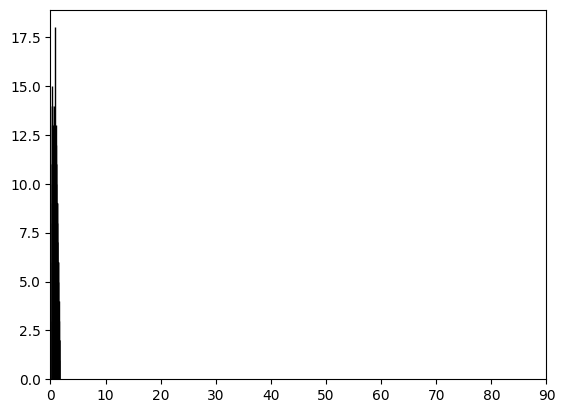

In [222]:
plt.hist(angles_avg_8.flatten(), bins=100, edgecolor='black', alpha=1)
plt.xlim(0, 90)
plt.show()
plt.hist(angles_avg_9.flatten(), bins=100, edgecolor='black', alpha=1)
plt.xlim(0, 90)
plt.show()
plt.hist(angles_avg_10.flatten(), bins=100, edgecolor='black', alpha=1)
plt.xlim(0, 90)
plt.show()
plt.hist(angles_avg_11.flatten(), bins=100, edgecolor='black', alpha=1)
plt.xlim(0, 90)
plt.show()

In [223]:
angles_mean = np.concatenate(
    (
    angles_avg_8.flatten(),
    angles_avg_9.flatten(),
    angles_avg_10.flatten(),
    np.tile(angles_avg_11.flatten(), 25)
    ),
    axis=0
)

ValueError: zero-dimensional arrays cannot be concatenated

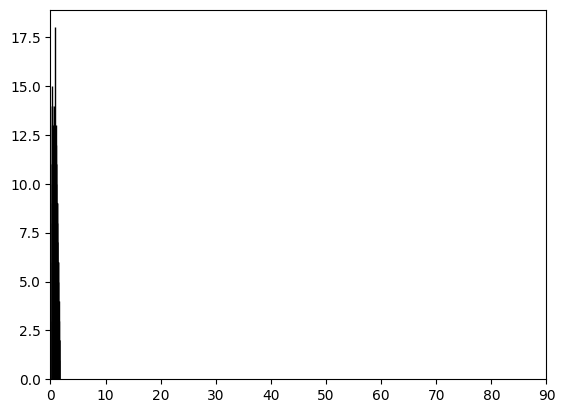

In [224]:
plt.hist(angles_mean, bins=100, edgecolor='black', alpha=1)
plt.xlim(0, 90)
plt.show()

In [225]:
print(np.mean(angles_mean))

0.7859263168622828
